In [167]:
# libs
import pandas as pd
import numpy as np
from datetime import datetime
import os

# bar plots
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
# today's date string for file namine automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
print(today_date_str)

_2024-02-26.csv


In [169]:
# cocncat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"

# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1266 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Relative Volume 1 week,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years
0,MSFT,Microsoft Corporation,NASDAQ,3034961571473.887,USD,408.4500,USD,1.06,USD,0.258322,...,0.02686712,0.945383,1.597040,1.517290,409.636667,36.94140205,Technology Services,0.954249,1.0329885,0.8991026
1,NVDA,NVIDIA Corporation,NASDAQ,1975724957160.079,USD,790.2900,USD,8.85,USD,1.122854,...,0.05753337,2.727202,6.121646,3.583778,793.933300,66.20784987,Electronic Technology,1.777562,2.2734668,1.6840769
2,AMZN,"Amazon.com, Inc.",NASDAQ,1814259997850.8013,USD,174.6600,USD,0.71,USD,0.405737,...,0.03263947,1.031105,1.852445,1.897577,175.200000,60.44435216,Retail Trade,1.122218,1.3340302,1.142365
3,BRK.B,Berkshire Hathaway Inc. New,NYSE,913421737403.8116,USD,420.8829,USD,4.38,USD,1.049806,...,0.123855,3.044307,1.530185,1.242365,423.560967,11.97040128,Finance,0.677712,0.86781585,0.8809025
4,BRK.A,Berkshire Hathaway Inc.,NYSE,912137843061.4086,USD,633559.9900,USD,7126.82,USD,1.133166,...,0.26540262,2.869860,1.681073,1.309302,637199.662933,12.01278649,Finance,0.653694,0.85174525,0.88295174


In [ ]:
# # first 10 rows df
# trading_view_raw_df_testing = trading_view_raw_df.head(10)
# # save to csv
# trading_view_raw_df_testing.to_csv('trading_view_raw_data/tv_screen_gap-up_testing.csv', index=False)
# # make sure data is there at least
# print(len(trading_view_raw_df_testing.index))

# # print test df
# trading_view_raw_df_testing

In [82]:
# # baseline raw cols from trading view initial filter
# features_raw_all = trading_view_raw_df.columns
# # convert to list
# features_raw_all = features_raw_all.tolist()
# # look at the trading view columns
# print(features_raw_all)

['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Relative Volume 1 day', 'Average Volume 10 days', 'Pre-market Volume', 'Relative Volume at Time', 'Relative Volume at Time.1', 'Volume 1 week', 'Relative Volume 1 week', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years']


In [ ]:
"""
define function -> add new column and marketCapType based on 'Market capitalization' column

criteria (6 groupings):
200B and above = 'Titans' - 1
10B to 200B = 'Large caps' - 2
2B to 10B = 'Midlers' - 3
300M to 2B = 'Small caps' - 4
300m and below = 'Micro caps' - 5
50m and below = 'Shrimp' - 6

"""

In [170]:
def categorize_market_cap(df):
    # Convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    
    # Define the conditions for each market cap category using regular number notation
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above

        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
       
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
       
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    
    # Define the category names corresponding to each condition
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    
    # Use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [171]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years,marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.034962e+12,USD,408.4500,USD,1.06,USD,0.258322,...,0.945383,1.597040,1.517290,409.636667,36.94140205,Technology Services,0.954249,1.0329885,0.8991026,Titans
1,NVDA,NVIDIA Corporation,NASDAQ,1.975725e+12,USD,790.2900,USD,8.85,USD,1.122854,...,2.727202,6.121646,3.583778,793.933300,66.20784987,Electronic Technology,1.777562,2.2734668,1.6840769,Titans
2,AMZN,"Amazon.com, Inc.",NASDAQ,1.814260e+12,USD,174.6600,USD,0.71,USD,0.405737,...,1.031105,1.852445,1.897577,175.200000,60.44435216,Retail Trade,1.122218,1.3340302,1.142365,Titans
3,BRK.B,Berkshire Hathaway Inc. New,NYSE,9.134217e+11,USD,420.8829,USD,4.38,USD,1.049806,...,3.044307,1.530185,1.242365,423.560967,11.97040128,Finance,0.677712,0.86781585,0.8809025,Titans
4,BRK.A,Berkshire Hathaway Inc.,NYSE,9.121378e+11,USD,633559.9900,USD,7126.82,USD,1.133166,...,2.869860,1.681073,1.309302,637199.662933,12.01278649,Finance,0.653694,0.85174525,0.88295174,Titans


In [ ]:
# # check for NaNs
# print(trading_view_raw_df.isna().sum())

In [172]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
# get simple count of NaNs total. should be 0
print(f'NaNs = {tv_df.isna().sum().sum()}')

# if there are no NaNs, print "No NaNs in DataFrame! Success!", else print the NaN count and "There are x NaNs in DataFrame, check your code dumb dumb!"
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")


NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [173]:
mc_groups = trading_view_raw_df['marketCapType'].value_counts().reset_index()
mc_groups.columns = ['marketCapType', 'count']  # Rename columns for clarity

# Calculate percentage for each market cap type and add it to the DataFrame
mc_groups['percentage'] = (mc_groups['count'] / mc_groups['count'].sum()) * 100

# Display the enhanced DataFrame
mc_groups

,marketCapType,count,percentage
0,Small caps,287,22.669826
1,Shrimp,249,19.668246
2,Midlers,245,19.352291
3,Large caps,224,17.693523
4,Micro caps,221,17.456556
5,Titans,26,2.053712
6,Undefined,14,1.105845


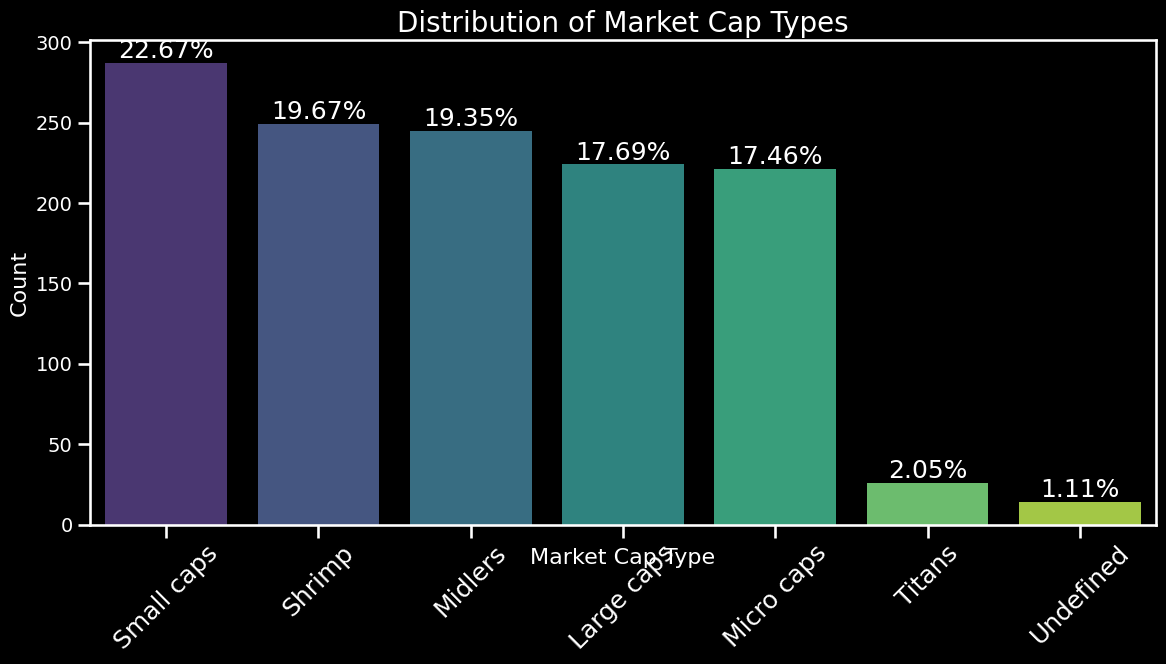

In [174]:
# Set dark mode for plotting
plt.style.use('dark_background')
sns.set_context('talk')  # Larger fonts and figures

# Create a bar chart with a modern and professional look
plt.figure(figsize=(12, 7))
# Assign 'marketCapType' to both x and hue, and explicitly disable the legend
barplot = sns.barplot(data=mc_groups, x='marketCapType', y='count', hue='marketCapType', palette='viridis', legend=False)

# After plotting, you can disable the legend that comes with using 'hue'
plt.legend([],[], frameon=False)

# Customize the plot with percentage labels
for index, row in mc_groups.iterrows():
    # Adjust the positioning based on your data for clarity
    barplot.text(index, row['count'], f'{row["percentage"]:.2f}%', color='white', ha="center", va="bottom")

# Add marketCapType labels underneath the bars
for index, row in mc_groups.iterrows():
    barplot.text(index, -10, row['marketCapType'], color='white', ha="center", va="top", rotation=45)

plt.title('Distribution of Market Cap Types', fontsize=20, color='white')
plt.xlabel('Market Cap Type', fontsize=16, color='white')
plt.ylabel('Count', fontsize=16, color='white')
plt.xticks(rotation=45, fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')

# Remove x-axis labels to avoid redundancy due to hue
barplot.set_xticklabels([])

# Show the plot
plt.tight_layout()
plt.show()

In [175]:
# print length of df
print(len(tv_df.index))
# print sample head
tv_df.sample(10)

1252


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years,marketCapType
206,AMCR,Amcor plc,NYSE,1.334775e+10,USD,9.235,USD,0.0100,USD,0.107875,...,0.760870,1.825153,1.879430,9.231667,20.97910041,Process Industries,0.827037,0.707972,0.8582027,Large caps
672,PHAT,"Phathom Pharmaceuticals, Inc.",NASDAQ,6.163234e+08,USD,10.765,USD,0.2700,USD,2.547170,...,2.075472,13.164381,9.941811,10.728333,-,Health Technology,1.088346,-0.12420815,0.47811124,Small caps
592,SOUN,"SoundHound AI, Inc.",NASDAQ,9.543624e+08,USD,3.865,USD,0.0200,USD,0.510204,...,3.645833,13.173773,10.091903,3.895000,-,Technology Services,3.593910,0.9849017,0.9849017,Small caps
140,AVB,"AvalonBay Communities, Inc.",NYSE,2.491076e+10,USD,175.500,USD,2.5700,USD,1.465222,...,1.112732,1.529152,1.607575,175.678333,26.83814534,Finance,0.986175,0.86537063,0.9378006,Large caps
779,CAN,Canaan Inc.,NASDAQ,3.061728e+08,USD,1.930,USD,0.0800,USD,4.469274,...,9.016393,14.536047,12.683175,1.905000,-,Electronic Technology,1.686579,2.290974,3.0484035,Small caps
958,GMFI,Aetherium Acquisition Corp.,NASDAQ,7.001981e+07,USD,10.950,USD,0.0400,USD,0.366636,...,0.365965,0.046204,0.063723,10.943333,89.16938111,Finance,-0.257070,0.01833911,0.01833911,Micro caps
821,CSPI,CSP Inc.,NASDAQ,2.394719e+08,USD,49.305,USD,1.0100,USD,2.161815,...,9.088766,25.748342,12.521685,49.131633,56.77683095,Technology Services,1.065613,0.12807651,1.0496112,Micro caps
1098,XELB,"Xcel Brands, Inc",NASDAQ,1.987806e+07,USD,1.000,USD,0.0599,USD,6.440168,...,8.990000,5.438801,5.669802,1.006667,-,Consumer Non-Durables,-0.029794,1.376082,1.5742148,Shrimp
437,MOR,MorphoSys AG,NASDAQ,2.662731e+09,USD,17.640,USD,0.0600,USD,0.340522,...,0.453643,1.027922,5.997903,17.658333,30.99086437,Health Technology,0.586523,1.0538778,1.0036536,Midlers
366,RELY,"Remitly Global, Inc.",NASDAQ,3.992001e+09,USD,21.560,USD,0.0600,USD,0.283822,...,2.956605,5.741074,3.612370,21.373333,-,Commercial Services,-0.659123,0.04400998,0.04400998,Midlers


In [176]:
# show unique values for 'marketCapType'
tv_df['marketCapType'].unique()

array(['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps',
       'Shrimp'], dtype=object)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [ ]:
# def stock_filter(df, pre_change_perc_min):
#     if pre_change_perc_min is not None:
#         df = df[df['Pre-market change'] > pre_change_perc_min]

In [182]:
# # get tv_df columns
# tv_df.columns

Index(['Symbol', 'Description', 'Exchange', 'Market capitalization',
       'Market capitalization - Currency', 'Price', 'Price - Currency',
       'Pre-market Change', 'Pre-market Change - Currency',
       'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding',
       'Volume 1 day', 'Relative Volume 1 day', 'Average Volume 10 days',
       'Pre-market Volume', 'Relative Volume at Time',
       'Relative Volume at Time.1', 'Volume 1 week', 'Relative Volume 1 week',
       'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month',
       'Volume Weighted Average Price 1 day', 'Price to earnings ratio',
       'Sector', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years',
       'marketCapType'],
      dtype='object')

In [179]:
# # market cap dataframes
# titans_df = tv_df[tv_df['marketCapType'] == 'Titans']
# large_caps_df = tv_df[tv_df['marketCapType'] == 'Large caps']
# midlers_df = tv_df[tv_df['marketCapType'] == 'Midlers']
# small_caps_df = tv_df[tv_df['marketCapType'] == 'Small caps']
# micro_caps_df = tv_df[tv_df['marketCapType'] == 'Micro caps']
# shrimp_df = tv_df[tv_df['marketCapType'] == 'Shrimp']

In [184]:
# def change_percent_filter(df, change_percent_min=None ):                               
#     if change_percent_min is not None:
#         df = df[df['Pre-market Change %'] >= change_percent_min]
#     return df  

In [186]:
# # EXECUTE change percent filter
# titans_df = change_percent_filter(titans_df, .005)
# large_caps_df = change_percent_filter(large_caps_df, .01)
# midlers_df = change_percent_filter(midlers_df, .02)
# small_caps_df = change_percent_filter(small_caps_df, .03)
# micro_caps_df = change_percent_filter(micro_caps_df, .04)
# shrimp_df = change_percent_filter(shrimp_df, .05)

In [190]:
# print(len(small_caps_df.index))

286


In [ ]:
# market cap filter function (percentage)

In [ ]:
# EXAMPLE IDEA for market cap groups
# microcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Micro-Cap']
# smallcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Small-Cap']
# midcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Mid-Cap']
# largecap_df = screener_df_x[screener_df_x['marketcapType'] == 'Large-Cap']
# megacap_df = screener_df_x[screener_df_x['marketcapType'] == 'Mega-Cap']

In [ ]:
# EXAMPLE IDEA for filtering by market cap
#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': '0.005',
#         'Large caps': '0.01',
#         'Midlers': '0.02',
#         'Small caps': '0.03',
#         'Micro caps': '0.04',
#         'Shrimp': '0.05'
#     }

# THEN we need filters using things like float, volatility, volume, etc. to further filter down the stocks

In [ ]:
# def filter_pre_market(df):
#     # Convert 'Pre-market Change %' to numeric, coercing errors to NaN
#     df['Pre-market Change %'] = pd.to_numeric(df['Pre-market Change %'].str.rstrip('%'), errors='coerce') / 100
    
#     # Check if conversion resulted in any non-NaN values
#     if df['Pre-market Change %'].isna().all():
#         print("Warning: 'Pre-market Change %' conversion resulted in all NaN values.")
    
#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': '0.005',
#         'Large caps': '0.01',
#         'Midlers': '0.02',
#         'Small caps': '0.03',
#         'Micro caps': '0.04',
#         'Shrimp': '0.05'
#     }

#     # Use the map to apply thresholds
#     threshold_map = df['marketCapType'].map(thresholds)
    
#     # Directly filter using the mapped thresholds
#     df_filtered = df[df['Pre-market Change %'] >= threshold_map]

#     # Diagnostic message to check if any rows meet the condition
#     if len(df_filtered) == 0:
#         print("No rows meet the threshold conditions.")
    
#     return df_filtered

# # Assuming tv_df is your initial DataFrame and it's already been categorized by market cap type
# print(f'Length before filtering: {len(tv_df.index)}')
# tv_df_filtered = filter_pre_market(tv_df)
# print(f'Length after filtering: {len(tv_df_filtered.index)}')


In [ ]:
# def filter_pre_market(df):
#     # Ensure 'Pre-market Change %' is numeric, coercing errors to NaN
#     df['Pre-market Change %'] = pd.to_numeric(df['Pre-market Change %'].str.rstrip('%'), errors='coerce') / 100

#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': 0.005,
#         'Large caps': 0.01,
#         'Midlers': 0.02,
#         'Small caps': 0.03,
#         'Micro caps': 0.04,
#         'Shrimp': 0.05
#     }

#     # Instead of iterating and filtering, use the map to apply thresholds and directly filter
#     threshold_map = df['marketCapType'].map(thresholds)
#     df_filtered = df[df['Pre-market Change %'] >= threshold_map]

#     return df_filtered

# # Assuming tv_df is your initial DataFrame and it's already been categorized by market cap type
# print(f'Length before filtering: {len(tv_df.index)}')
# tv_df = filter_pre_market(tv_df)
# print(f'Length after filtering: {len(tv_df.index)}')


,marketCapType,count
0,Large caps,266
1,Small caps,245
2,Shrimp,219
3,Midlers,215
4,Micro caps,183
5,Titans,27


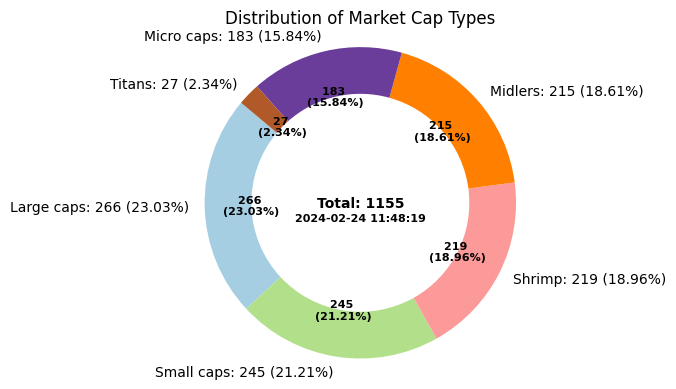

In [74]:
# from IPython.display import display, HTML
# import matplotlib.pyplot as plt
# from datetime import datetime
# import numpy as np

# # Assuming mc_groups is your DataFrame
# # Convert DataFrame to HTML and add custom styling for clearer, larger display
# html = mc_groups.to_html(classes='table table-striped')
# style = """
# <style>
#     .table {float: left; margin-right: 20px;}
#     .table th, .table td {font-size: 18px;}
# </style>
# """
# display(HTML(style + html))

# # Now, plot the donut chart, scaled down a bit, next to the DataFrame
# fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size to scale down the chart

# # Pie chart code here, modified to fit the new figure size
# # Assume your labels, sizes, percentages, and colors are defined as before

# wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, startangle=140,
#                                   autopct='', pctdistance=0.85, wedgeprops=dict(width=0.3))

# # Customizing texts inside the donut as before
# for i, p in enumerate(wedges):
#     angle = (p.theta2 - p.theta1) / 2. + p.theta1
#     y = np.sin(np.deg2rad(angle))
#     x = np.cos(np.deg2rad(angle))
#     percentage = f'{sizes[i]} \n({percentages[i]:.2f}%)'
#     ax.text(x*0.7, y*0.7, percentage, ha='center', va='center', fontsize=8, color='black', weight='bold')

# ax.set_title('Distribution of Market Cap Types', fontsize=12)
# ax.text(0, 0, f'Total: {sizes.sum()}', ha='center', va='center', fontsize=10, color='black', weight='bold')
# ax.text(0, -0.1, datetime.now().strftime('%Y-%m-%d %H:%M:%S'), ha='center', va='center', fontsize=8, color='black', weight='bold')

# plt.axis('equal')
# plt.tight_layout()
# plt.show()


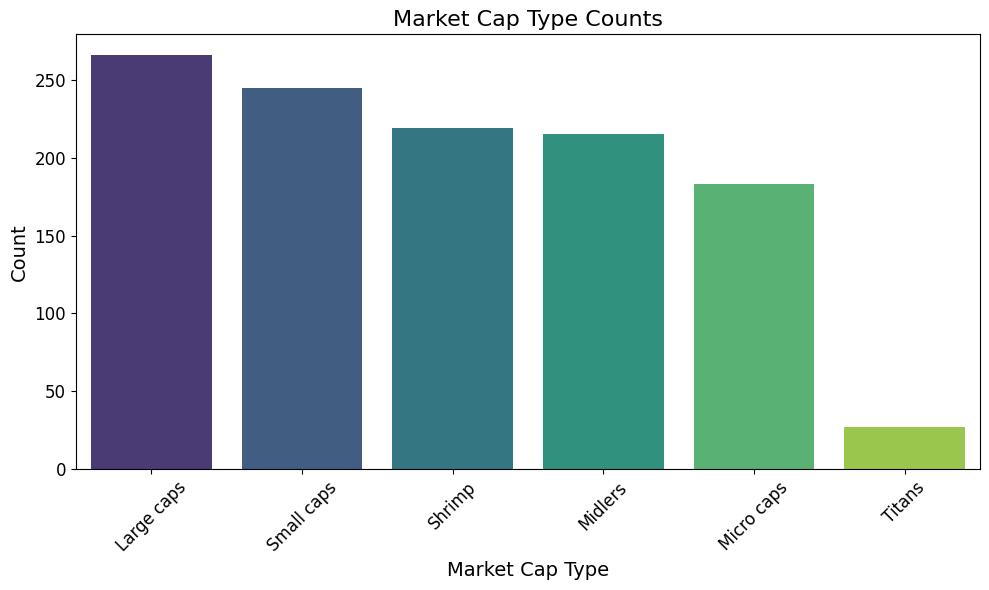

In [62]:
# plt.figure(figsize=(10, 6))
# # Assign 'marketCapType' to both x and hue, and disable the legend.
# sns.barplot(data=mc_groups, x='marketCapType', y='count', hue='marketCapType', palette='viridis', legend=False)
# plt.title('Market Cap Type Counts', fontsize=16)
# plt.xlabel('Market Cap Type', fontsize=14)
# plt.ylabel('Count', fontsize=14)
# plt.xticks(rotation=45, fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()

# # Since we're now using 'hue', you'll need to remove the legend explicitly if it still appears.
# plt.legend([],[], frameon=False)

# plt.show()

In [ ]:
# feature selection
# features = ['Market capitalization', 'Volume 1 day', 'Volatility 1 week', 'Beta 1 year', 'Sector']
# features = features_raw_all
# target = 'Post-market Change %'

# # Preprocessing data: Drop rows with missing values in the selected columns
# tv_clean_df = trading_view_raw_df[features + [target]].dropna()

# # Check the unique values and their frequency for the target variable
# print(tv_clean_df['Post-market Change %'].value_counts())


# # Encoding categorical variables and scaling numerical variables
# categorical_features = ['Sector']
# numeric_features = list(set(features) - set(categorical_features))

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ])

# # Prepare the data for modeling
# X = tv_clean_df[features]
# y = tv_clean_df[target]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define and fit the model
# model = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('regressor', LinearRegression())])

# model.fit(X_train, y_train)

# # Predict and evaluate the model
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'MSE: {mse}')
# print(f'R^2: {r2}')

# # For detailed statistics, we need to fit the model using statsmodels
# # We'll prepare the data again because statsmodels requires it to be done differently
# X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
# X_train_transformed = sm.add_constant(X_train_transformed)  # Adding a constant for the intercept

# # Fit the model using OLS
# ols_model = sm.OLS(y_train, X_train_transformed).fit()

# # Print the summary of the model to see detailed statistics
# print(ols_model.summary())
